# CRAFT fine-tuning and inference interactive demo

This example notebook shows how to fine-tune a pretrained CRAFT conversational model for the task of forecasting conversational derailment, as shown in the "Trouble on the Horizon" paper (note however that due to nondeterminism in the training process, the results will not exactly reproduce the ones shown in the paper; if you need the exact inference results from the paper, see our [online demo](https://colab.research.google.com/drive/1GvICZN0VwZQSWw3pJaEVY-EQGoO-L5lH) that does inference only using the saved already-fine-tuned model from the paper).

In [1]:
# import necessary libraries, including convokit
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
import unicodedata
import itertools
from convokit import download, Corpus

# import all configuration variables
from model.config import *
# import data preprocessing functions
from model.data import *
# import our custom PyTorch modules
from model.model import *

%matplotlib inline

# Given a ConvoKit conversation, preprocess each utterance's text by tokenizing and truncating.
# Returns the processed dialog entry where text has been replaced with a list of
# tokens, each no longer than MAX_LENGTH - 1 (to leave space for the EOS token)
def processDialog(voc, dialog):
    processed = []
    C_b_a = dialog.meta['mean_C_b_a']
    C_a_b = dialog.meta['mean_C_a_b']
    LSM = dialog.meta['mean_LSM']
    for utterance in dialog.iter_utterances():
        # skip the section header, which does not contain conversational content
        if utterance.meta['is_section_header']:
            continue
        tokens = tokenize(utterance.text)
        # replace out-of-vocabulary tokens
        for i in range(len(tokens)):
            if tokens[i] not in voc.word2index:
                tokens[i] = "UNK"
        processed.append({"tokens": tokens, 
                          "is_attack": int(utterance.meta['comment_has_personal_attack']), 
                          "id": utterance.id,
                          'C_b_a' : C_b_a,
                          'C_a_b' : C_a_b,
                          'LSM' : LSM})
        
    return processed

# Load context-reply pairs from the Corpus, optionally filtering to only conversations
# from the specified split (train, val, or test).
# Each conversation, which has N comments (not including the section header) will
# get converted into N-1 comment-reply pairs, one pair for each reply 
# (the first comment does not reply to anything).
# Each comment-reply pair is a tuple consisting of the conversational context
# (that is, all comments prior to the reply), the reply itself, the label (that
# is, whether the reply contained a derailment event), and the comment ID of the
# reply (for later use in re-joining with the ConvoKit corpus).
# The function returns a list of such pairs.
def loadPairs(voc, corpus, split=None, last_only=False):
    pairs = []
    for convo in corpus.iter_conversations():
        # consider only conversations in the specified split of the data
        if split is None or convo.meta['split'] == split:
            dialog = processDialog(voc, convo)
            iter_range = range(1, len(dialog)) if not last_only else [len(dialog)-1]
            for idx in iter_range:
                reply = dialog[idx]["tokens"][:(MAX_LENGTH-1)]
                label = dialog[idx]["is_attack"]
                comment_id = dialog[idx]["id"]
                # gather as context all utterances preceding the reply
                context = [u["tokens"][:(MAX_LENGTH-1)] for u in dialog[:idx]]

                C_b_a = dialog[idx]['C_b_a']
                C_a_b = dialog[idx]['C_a_b']
                LSM = dialog[idx]['LSM']

                if C_b_a == None:
                    continue
                else:
                    pairs.append((context, reply, label, comment_id, C_b_a, C_a_b, LSM))
    return pairs

if corpus_name == "wikiconv":
    # corpus = Corpus(filename=download("conversations-gone-awry-corpus"))
    corpus = Corpus(filename=r'C:\Users\ewais\Documents\GitHub\LSA-online-arguments\preprocessed corpus\preprocessed_wikipedia_corpus')
elif corpus_name == "cmv":
    # corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus"))
    corpus = Corpus(filename=r'C:\Users\ewais\Documents\GitHub\LSA-online-arguments\preprocessed corpus\preprocessed_reddit_corpus')

# First, we need to build the vocabulary so that we know how to map tokens to tensor indicies.
# For the sake of replicating the paper results, we will load the pre-computed vocabulary objects used in the paper.
voc = loadPrecomputedVoc(corpus_name, word2index_path, index2word_path)

# Convert the test set data into a list of input/label pairs. Each input will represent the conversation as a list of lists of tokens.
train_pairs = loadPairs(voc, corpus, "train", last_only=True)
val_pairs = loadPairs(voc, corpus, "val", last_only=True)
test_pairs = loadPairs(voc, corpus, "test")

class Predictor(nn.Module):
    """This helper module encapsulates the CRAFT pipeline, defining the logic of passing an input through each consecutive sub-module."""
    def __init__(self, encoder, context_encoder, classifier):
        super(Predictor, self).__init__()
        self.encoder = encoder
        self.context_encoder = context_encoder
        self.classifier = classifier
        
    def forward(self, input_batch, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, max_length, C_b_a, C_a_b, LSM):
        # Forward input through encoder model
        _, utt_encoder_hidden = self.encoder(input_batch, utt_lengths)
        
        # Convert utterance encoder final states to batched dialogs for use by context encoder
        context_encoder_input = makeContextEncoderInput(utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices)
        
        # Forward pass through context encoder
        context_encoder_outputs, context_encoder_hidden = self.context_encoder(context_encoder_input, dialog_lengths)
        
        # Forward pass through classifier to get prediction logits
        logits = self.classifier(context_encoder_outputs, dialog_lengths, C_b_a, C_a_b, LSM)
        
        # Apply sigmoid activation
        predictions = F.sigmoid(logits)
        return predictions

def train(input_variable, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, labels, # input/output arguments
          encoder, context_encoder, attack_clf,                                                                    # network arguments
          encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer,                                      # optimization arguments
          batch_size, clip,                                                                                        # misc arguments
          C_b_a = None, C_a_b = None, LSM = None, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    context_encoder_optimizer.zero_grad()
    attack_clf_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    labels = labels.to(device)
    

    # Forward pass through utterance encoder
    _, utt_encoder_hidden = encoder(input_variable, utt_lengths)
    
    # Convert utterance encoder final states to batched dialogs for use by context encoder
    context_encoder_input = makeContextEncoderInput(utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices)
    
    # Forward pass through context encoder
    context_encoder_outputs, _ = context_encoder(context_encoder_input, dialog_lengths)

    # Forward pass through classifier to get prediction logits
    logits = attack_clf(context_encoder_outputs, dialog_lengths, C_b_a, C_a_b, LSM)

    # Calculate loss
    loss = F.binary_cross_entropy_with_logits(logits, labels)

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(context_encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(attack_clf.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    context_encoder_optimizer.step()
    attack_clf_optimizer.step()

    return loss.item()

def evaluateBatch(encoder, context_encoder, predictor, voc, input_batch, dialog_lengths, 
                  dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, device,                      C_b_a = None, C_a_b = None, LSM = None, max_length=MAX_LENGTH):
    # Set device options
    input_batch = input_batch.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    # Predict future attack using predictor
    scores = predictor(input_batch, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, max_length, C_b_a, C_a_b, LSM)
    predictions = (scores > 0.5).float()
    return predictions, scores

def validate(dataset, encoder, context_encoder, predictor, voc, batch_size, device):
    # create a batch iterator for the given data
    batch_iterator = batchIterator(voc, dataset, batch_size, shuffle=False)
    # find out how many iterations we will need to cover the whole dataset
    n_iters = len(dataset) // batch_size + int(len(dataset) % batch_size > 0)
    # containers for full prediction results so we can compute accuracy at the end
    all_preds = []
    all_labels = []
    for iteration in range(1, n_iters+1):
        batch, batch_dialogs, _, true_batch_size, C_b_a, C_a_b, LSM = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, convo_ids, target_variable, mask, max_target_len = batch
        dialog_lengths_list = [len(x) for x in batch_dialogs]
        # run the model
        predictions, scores = evaluateBatch(encoder, context_encoder, predictor, voc, input_variable,
                                            dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, true_batch_size, device, C_b_a, C_a_b, LSM)
        # aggregate results for computing accuracy at the end
        all_preds += [p.item() for p in predictions]
        all_labels += [l.item() for l in labels]
        print("Iteration: {}; Percent complete: {:.1f}%".format(iteration, iteration / n_iters * 100))

    # compute and return the accuracy
    return (np.asarray(all_preds) == np.asarray(all_labels)).mean()

def trainIters(voc, pairs, val_pairs, encoder, context_encoder, attack_clf,
               encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer, embedding,
               n_iteration, batch_size, print_every, validate_every, clip):
    
    # create a batch iterator for training data
    batch_iterator = batchIterator(voc, pairs, batch_size)
    
    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0

    # Training loop
    print("Training...")
    # keep track of best validation accuracy - only save when we have a model that beats the current best
    best_acc = 0
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch, training_dialogs, _, true_batch_size, C_b_a, C_a_b, LSM = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, _, target_variable, mask, max_target_len = training_batch
        dialog_lengths_list = [len(x) for x in training_dialogs]

        # Run a training iteration with batch
        loss = train(input_variable, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, labels, # input/output arguments
                     encoder, context_encoder, attack_clf,                                                                    # network arguments
                     encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer,                                      # optimization arguments
                     true_batch_size, clip,                                                                                   # misc arguments
                     C_b_a, C_a_b, LSM)
        print_loss += loss
        
        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Evaluate on validation set
        if (iteration % validate_every == 0):
            print("Validating!")
            # put the network components into evaluation mode
            encoder.eval()
            context_encoder.eval()
            attack_clf.eval()
            
            predictor = Predictor(encoder, context_encoder, attack_clf)
            accuracy = validate(val_pairs, encoder, context_encoder, predictor, voc, batch_size, device)
            print("Validation set accuracy: {:.2f}%".format(accuracy * 100))

            # keep track of our best model so far
            if accuracy > best_acc:
                print("Validation accuracy better than current best; saving model...")
                best_acc = accuracy
                torch.save({
                    'iteration': iteration,
                    'en': encoder.state_dict(),
                    'ctx': context_encoder.state_dict(),
                    'atk_clf': attack_clf.state_dict(),
                    'en_opt': encoder_optimizer.state_dict(),
                    'ctx_opt': context_encoder_optimizer.state_dict(),
                    'atk_clf_opt': attack_clf_optimizer.state_dict(),
                    'loss': loss,
                    'voc_dict': voc.__dict__,
                    'embedding': embedding.state_dict()
                }, os.path.join(save_dir, "finetuned_model.tar"))
            
            # put the network components back into training mode
            encoder.train()
            context_encoder.train()
            attack_clf.train()

def evaluateDataset(dataset, encoder, context_encoder, predictor, voc, batch_size, device):
    # create a batch iterator for the given data
    batch_iterator = batchIterator(voc, dataset, batch_size, shuffle=False)
    # find out how many iterations we will need to cover the whole dataset
    n_iters = len(dataset) // batch_size + int(len(dataset) % batch_size > 0)
    output_df = {
        "id": [],
        "prediction": [],
        "score": []
    }
    for iteration in range(1, n_iters+1):
        batch, batch_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, convo_ids, target_variable, mask, max_target_len = batch
        dialog_lengths_list = [len(x) for x in batch_dialogs]
        # run the model
        predictions, scores = evaluateBatch(encoder, context_encoder, predictor, voc, input_variable,
                                            dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices,
                                            true_batch_size, device)

        # format the output as a dataframe (which we can later re-join with the corpus)
        for i in range(true_batch_size):
            convo_id = convo_ids[i]
            pred = predictions[i].item()
            score = scores[i].item()
            output_df["id"].append(convo_id)
            output_df["prediction"].append(pred)
            output_df["score"].append(score)
                
        print("Iteration: {}; Percent complete: {:.1f}%".format(iteration, iteration / n_iters * 100))

    return pd.DataFrame(output_df).set_index("id")

In [2]:
# Fix random state (affect native Python code only, does not affect PyTorch and hence does not guarantee reproducibility)
random.seed(2019)

# Tell torch to use GPU. Note that if you are running this notebook in a non-GPU environment, you can change 'cuda' to 'cpu' to get the code to run.
device = torch.device('cuda')

print("Loading saved parameters...")
if not os.path.isfile(os.path.join(save_dir, "model.tar")):
    raise RuntimeError("Pretrained model not found. Have you run pretraining using train_generative_model.py?")
checkpoint = torch.load(os.path.join(save_dir, "model.tar"))
# If running in a non-GPU environment, you need to tell PyTorch to convert the parameters to CPU tensor format.
# To do so, replace the previous line with the following:
#checkpoint = torch.load("model.tar", map_location=torch.device('cpu'))
encoder_sd = checkpoint['en']
context_sd = checkpoint['ctx']
embedding_sd = checkpoint['embedding']
voc.__dict__ = checkpoint['voc_dict']

print('Building encoders, decoder, and classifier...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(embedding_sd)
# Initialize utterance and context encoders
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
context_encoder = ContextEncoderRNN(hidden_size, context_encoder_n_layers, dropout)
encoder.load_state_dict(encoder_sd)
context_encoder.load_state_dict(context_sd)
# Initialize classifier
attack_clf = SingleTargetClf(hidden_size, dropout)
# Use appropriate device
encoder = encoder.to(device)
context_encoder = context_encoder.to(device)
attack_clf = attack_clf.to(device)
print('Models built and ready to go!')

# Compute the number of training iterations we will need in order to achieve the number of epochs specified in the settings at the start of the notebook
n_iter_per_epoch = len(train_pairs) // batch_size + int(len(train_pairs) % batch_size == 1)
n_iteration = n_iter_per_epoch * finetune_epochs

# Put dropout layers in train mode
encoder.train()
context_encoder.train()
attack_clf.train()

# Initialize optimizers
print('Building optimizers...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=labeled_learning_rate)
context_encoder_optimizer = optim.Adam(context_encoder.parameters(), lr=labeled_learning_rate)
attack_clf_optimizer = optim.Adam(attack_clf.parameters(), lr=labeled_learning_rate)

# Run training iterations, validating after every epoch
print("Starting Training!")
print("Will train for {} iterations".format(n_iteration))
trainIters(voc, train_pairs, val_pairs, encoder, context_encoder, attack_clf,
           encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer, embedding,
           n_iteration, batch_size, print_every, n_iter_per_epoch, clip)

Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!
Building optimizers...
Starting Training!
Will train for 150 iterations
Initializing ...
Training...
Validating!
Iteration: 1; Percent complete: 50.0%
Iteration: 2; Percent complete: 100.0%C:\Users\ewais\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")

Validation set accuracy: 43.59%
Validation accuracy better than current best; saving model...
Iteration: 10; Percent complete: 6.7%; Average loss: 0.6975
Validating!
Iteration: 1; Percent complete: 50.0%
Iteration: 2; Percent complete: 100.0%
Validation set accuracy: 43.59%
Validating!
Iteration: 1; Percent complete: 50.0%
Iteration: 2; Percent complete: 100.0%
Validation set accuracy: 43.59%
Iteration: 20; Percent complete: 13.3%; Average l

## Notes on training

trainIters is the main training loop

It looks like this will need to be implemented in LuongAttnDecoderRNN

## In ~\data\batchIterator:

- source_data\[ i \] = i'th training tuple, containing
    - context
    - reply
    - label
    - ID
- batch_dialogs

To preprocess our data:

Create source_data structure from only the conversations we can use for training data. Include an extra parameter in source_data for linguistic accommodation. Pass this to train() which will then be used in conjuction with the context_encoder output in the final MLP in order to train. Can adjust SingleTargetClf to implement this.

We can start by creating a custom corpus, with linguistic accommodation noted. This can be extracted using load_pairs() defined above. Then, extract it as a feature and pipe it down to the final MLP.

In order to do this efficiently, modify processDialog in data.py, so that the "processed" list it returns includes a key-value pair of linguistic accommodation features.

## Strategy to integrate
Start by running through the corpus itself via conversations, and for each conversation, figure out whether it includes valid input for our test. If it does, set a key-value pair "LSA_valid : True" and otherwise "LSA_valid : False". Once this is established for the whole corpus, iterate through it again and append to the conversations with "LSA_valid = True" the accommodation from speaker a to b, the accommodation from speaker b to a, and the symmetric style accommodation.

There is a function defined above called "load_pairs," this can be modified to return specific values for the accommodation with each pair. Take care to modify "iter_pair

## Part 7: run test set evaluation

Now that we have successfully fine-tuned the model, we run it on the test set so that we can evaluate performance.

In [14]:
# Fix random state for reproducibility
random.seed(2019)

# Tell torch to use GPU. Note that if you are running this notebook in a non-GPU environment, you can change 'cuda' to 'cpu' to get the code to run.
device = torch.device('cuda')

print("Loading saved parameters...")
checkpoint = torch.load(os.path.join(save_dir, "finetuned_model.tar"))
# If running in a non-GPU environment, you need to tell PyTorch to convert the parameters to CPU tensor format.
# To do so, replace the previous line with the following:
#checkpoint = torch.load("model.tar", map_location=torch.device('cpu'))
encoder_sd = checkpoint['en']
context_sd = checkpoint['ctx']
attack_clf_sd = checkpoint['atk_clf']
embedding_sd = checkpoint['embedding']
voc.__dict__ = checkpoint['voc_dict']

print('Building encoders, decoder, and classifier...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(embedding_sd)
# Initialize utterance and context encoders
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
context_encoder = ContextEncoderRNN(hidden_size, context_encoder_n_layers, dropout)
encoder.load_state_dict(encoder_sd)
context_encoder.load_state_dict(context_sd)
# Initialize classifier
attack_clf = SingleTargetClf(hidden_size, dropout)
attack_clf.load_state_dict(attack_clf_sd)
# Use appropriate device
encoder = encoder.to(device)
context_encoder = context_encoder.to(device)
attack_clf = attack_clf.to(device)
print('Models built and ready to go!')

# Set dropout layers to eval mode
encoder.eval()
context_encoder.eval()
attack_clf.eval()

# Initialize the pipeline
predictor = Predictor(encoder, context_encoder, attack_clf)

# Run the pipeline!
forecasts_df = evaluateDataset(test_pairs, encoder, context_encoder, predictor, voc, batch_size, device)

Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!
Iteration: 1; Percent complete: 1.4%
Iteration: 2; Percent complete: 2.9%
Iteration: 3; Percent complete: 4.3%
Iteration: 4; Percent complete: 5.8%
Iteration: 5; Percent complete: 7.2%
Iteration: 6; Percent complete: 8.7%
Iteration: 7; Percent complete: 10.1%
Iteration: 8; Percent complete: 11.6%
Iteration: 9; Percent complete: 13.0%
Iteration: 10; Percent complete: 14.5%
Iteration: 11; Percent complete: 15.9%
Iteration: 12; Percent complete: 17.4%
Iteration: 13; Percent complete: 18.8%
Iteration: 14; Percent complete: 20.3%
Iteration: 15; Percent complete: 21.7%
Iteration: 16; Percent complete: 23.2%
Iteration: 17; Percent complete: 24.6%
Iteration: 18; Percent complete: 26.1%
Iteration: 19; Percent complete: 27.5%
Iteration: 20; Percent complete: 29.0%
Iteration: 21; Percent complete: 30.4%
Iteration: 22; Percent complete: 31.9%
Iteration: 23; Percent complete: 33.3%
Iteration: 24;

In [15]:
# Inspect some of the outputs as a sanity-check
forecasts_df.head(20)

,prediction,score
id,,
191681310.17214.17214,0.0,0.397591
193088419.20001.20001,1.0,0.654389
191149920.17102.17102,0.0,0.239742
192892110.19259.19259,1.0,0.597574
190192199.17060.17060,0.0,0.170675
192890095.19227.19227,1.0,0.646455
190192005.17004.17004,0.0,0.146115
192885632.19156.19156,0.0,0.453823
190191827.16918.16918,0.0,0.201450


## Part 8: merge predictions back into corpus and evaluate

Now that the hard part is done, all that is left to do is to evaluate the predictions. Since the predictions are in no particular order, we will first merge each prediction back into the source corpus, and then evaluate each conversation according to the order of utterances within that conversation.

In [16]:
# We will add a metadata entry to each test-set utterance signifying whether it was FORECAST to be a derailment.
# Note that there is an important subtlety in how this metadata field is to be interpreted - the forecast for a given
# utterance is made BEFORE the model actually sees the utterance. That is, the forecast does not mean "the model thinks
# this utterance *is* a derailment" but rather that "based on the context of all preceding utterances, the model predicted,
# prior to actually seeing this utterance, that this utterance *would be* a derailment".
for convo in corpus.iter_conversations():
    # only consider test set conversations (we did not make predictions for the other ones)
    if convo.meta['split'] == "test":
        for utt in convo.iter_utterances():
            if utt.id in forecasts_df.index:
                utt.meta['forecast_score'] = forecasts_df.loc[utt.id].score

In [18]:
# Finally, we can use the forecast-annotated corpus to compute the forecast accuracy.
# Though we have an individual forecast per utterance, ground truth is at the conversation level:
# either a conversation derails or it does not. Thus, forecast accuracy is computed as follows:
#   - True positives are cases that actually derail, for which the model made at least one positive forecast ANYTIME prior to derailment
#   - False positives are cases that don't derail but for which the model made at least one positive forecast
#   - False negatives are cases that derail but for which the model made no positive forecasts prior to derailment
#   - True negatives are cases that don't derail, for which the model made no positive forecasts
# Note that by construction, the last comment of each conversation is the one marked as derailment, and that our earlier code was therefore
# set up to not look at the last comment, meaning that all forecasts we obtained are forecasts made prior to derailment. This simplifies
# the computation of forecast accuracy as we now do not need to explicitly consider when a forecast was made.

conversational_forecasts_df = {
    "convo_id": [],
    "label": [],
    "score": [],
    "prediction": []
}

for convo in corpus.iter_conversations():
    if convo.meta['split'] == "test":
        conversational_forecasts_df['convo_id'].append(convo.id)
        conversational_forecasts_df['label'].append(int(convo.meta[label_metadata]))
        forecast_scores = [utt.meta['forecast_score'] for utt in convo.iter_utterances() if 'forecast_score' in utt.meta]
        conversational_forecasts_df['score'] = np.max(forecast_scores)
        conversational_forecasts_df['prediction'].append(int(np.max(forecast_scores) > forecast_thresh))

conversational_forecasts_df = pd.DataFrame(conversational_forecasts_df).set_index("convo_id")
print((conversational_forecasts_df.label == conversational_forecasts_df.prediction).mean())

0.6488095238095238


In [19]:
# in addition to accuracy, we can also consider applying other metrics at the conversation level, such as precision/recall
def get_pr_stats(preds, labels):
    tp = ((labels==1)&(preds==1)).sum()
    fp = ((labels==0)&(preds==1)).sum()
    tn = ((labels==0)&(preds==0)).sum()
    fn = ((labels==1)&(preds==0)).sum()
    print("Precision = {0:.4f}, recall = {1:.4f}".format(tp / (tp + fp), tp / (tp + fn)))
    print("False positive rate =", fp / (fp + tn))
    print("F1 =", 2 / (((tp + fp) / tp) + ((tp + fn) / tp)))

get_pr_stats(conversational_forecasts_df.prediction, conversational_forecasts_df.label)

Precision = 0.6233, recall = 0.7524
False positive rate = 0.45476190476190476
F1 = 0.6817691477885652


## Part 9: model analysis: how early is early warning?

The goal of CRAFT is to forecast outcomes in advance, but how far in advance does it typically make its prediction? Following the paper, we measure this in two ways: the number of *comments* between the first prediction and the actual derailment, and how much *elapsed time* that gap actually translates to.

In [21]:
comments_until_derail = {} # store the "number of comments until derailment" metric for each conversation
time_until_derail = {} # store the "time until derailment" metric for each conversation

for convo in corpus.iter_conversations():
    if convo.meta['split'] == "test" and convo.meta[label_metadata]:
        # filter out the section header as usual
        utts = [utt for utt in convo.iter_utterances() if not utt.meta['is_section_header']]
        # by construction, the last comment is the one with the personal attack
        derail_idx = len(utts) - 1
        # now scan the utterances in order until we find the first derailment prediction (if any)
        for idx in range(1, len(utts)):
            if utts[idx].meta['forecast_score'] > forecast_thresh:
                # recall that the forecast_score meta field specifies what CRAFT thought this comment would look like BEFORE it
                # saw this comment. So the actual CRAFT forecast is made during the previous comment; we account for this by 
                # subtracting 1 from idx
                comments_until_derail[convo.id] = derail_idx - (idx-1)
                time_until_derail[convo.id] = utts[derail_idx].timestamp - utts[(idx-1)].timestamp
                break

In [22]:
# compute some quick statistics about the distribution of the "number of comments until derailment" metric
comments_until_derail_vals = np.asarray(list(comments_until_derail.values()))
print(np.min(comments_until_derail_vals), np.max(comments_until_derail_vals), np.median(comments_until_derail_vals), np.mean(comments_until_derail_vals))

1 12 3.0 3.4082278481012658


In [23]:
# compute some quick statistics about the distribution of the "time until derailment" metric
# note that since timestamps are in seconds, we convert to hours by dividing by 3600, to make it more human readable
time_until_derail_vals = np.asarray(list(time_until_derail.values())) / 3600
print(np.min(time_until_derail_vals), np.max(time_until_derail_vals), np.median(time_until_derail_vals), np.mean(time_until_derail_vals))

0.0 25575.071111111112 3.539861111111111 241.3298628691983


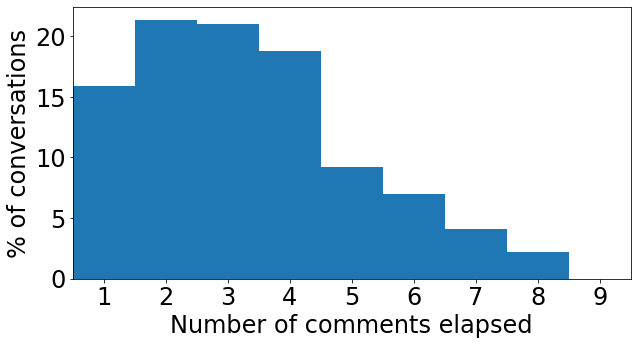

In [24]:
# visualize the distribution of "number of comments until derailment" as a histogram (reproducing Figure 4 from the paper)
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['font.size'] = 24
plt.hist(comments_until_derail_vals, bins=range(1, np.max(comments_until_derail_vals)), density=True)
plt.xlim(1,10)
plt.xticks(np.arange(1,10)+0.5, np.arange(1,10))
plt.yticks(np.arange(0,0.25,0.05), np.arange(0,25,5))
plt.xlabel("Number of comments elapsed")
plt.ylabel("% of conversations")
plt.show()